In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [136]:
with open('song_df_aggregate.pkl', 'rb') as f:
        song_df= pickle.load(f)  

In [137]:
song_df["top10"] = song_df["bestrank"] <50

In [138]:
to_pop =["artist","title","isnew","rank","date","spotify_id","spotify_explicit",
             "spotify_album_id","spotify_album_release_date","spotify_album_release_date_precision","album_label",
             "join","spotify_album_release_date_datetime","firstrank","numberofappearances","spotify_disc_number","spotify_mode","spotify_time_signature","num_artists","gold_count","platinum_count","spotify_track_number"]
[song_df.pop(i) for i in to_pop]
song_df.pop("last_award_type")
song_df.pop("spotify_key")
song_df.pop("bestrank")

0         1
1         2
2         1
3         1
4         1
       ... 
8514     79
8515     93
8516     95
8517     99
8518    100
Name: bestrank, Length: 8519, dtype: int64

In [139]:
song_df.pop("artist_has_award")
song_df = song_df.dropna()
top10 = song_df.pop("top10")


In [140]:
to_pop =["top50","top25","top75","top5","label_appearance_count","label_category","label_category_group"]
[song_df.pop(i) for i in to_pop]

[0        True
 1        True
 2        True
 3        True
 4        True
         ...  
 8514    False
 8515    False
 8516    False
 8517    False
 8518    False
 Name: top10, Length: 8269, dtype: bool, 0        True
 1        True
 2        True
 3        True
 4        True
         ...  
 8514    False
 8515    False
 8516    False
 8517    False
 8518    False
 Name: top25, Length: 8269, dtype: bool, 0        True
 1        True
 2        True
 3        True
 4        True
         ...  
 8514    False
 8515    False
 8516    False
 8517    False
 8518    False
 Name: top50, Length: 8269, dtype: bool, 0        True
 1        True
 2        True
 3        True
 4        True
         ...  
 8514    False
 8515    False
 8516    False
 8517    False
 8518    False
 Name: top5, Length: 8269, dtype: bool, 0         1.0
 1       107.0
 2        76.0
 3       211.0
 4        70.0
         ...  
 8514     60.0
 8515     69.0
 8516      2.0
 8517     73.0
 8518     98.0
 Name: label_app

In [141]:
X_train, X_test, y_train, y_test = train_test_split(song_df, top10, test_size=0.3)

In [142]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)


#can replace 'is_unbalance': 'true', by 'scale_pos_weight': 10,

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'is_unbalance': 'true',
    'num_leaves': 25,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_train,
                       num_boost_round=100,
                       early_stopping_rounds=100)

predictions = model.predict(X_test)


[1]	training's auc: 0.593521
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.62308
[3]	training's auc: 0.642952
[4]	training's auc: 0.654634
[5]	training's auc: 0.662763
[6]	training's auc: 0.672843
[7]	training's auc: 0.679112
[8]	training's auc: 0.683784
[9]	training's auc: 0.690531
[10]	training's auc: 0.691998
[11]	training's auc: 0.693738
[12]	training's auc: 0.694877
[13]	training's auc: 0.699273
[14]	training's auc: 0.703327
[15]	training's auc: 0.705767
[16]	training's auc: 0.708505
[17]	training's auc: 0.710435
[18]	training's auc: 0.71194
[19]	training's auc: 0.714415
[20]	training's auc: 0.715283
[21]	training's auc: 0.718898
[22]	training's auc: 0.722293
[23]	training's auc: 0.728097
[24]	training's auc: 0.732729
[25]	training's auc: 0.737776
[26]	training's auc: 0.739921
[27]	training's auc: 0.742134
[28]	training's auc: 0.743559
[29]	training's auc: 0.745886
[30]	training's auc: 0.746413
[31]	training's auc: 0.748963
[32]	training's auc

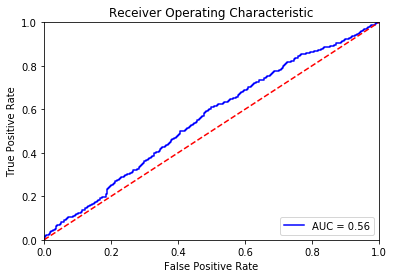

In [143]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [122]:
# Record the feature importances
feature_importances = model.feature_importance()
for i in range(len(feature_importances)):
    print(feature_importances[i],X_train.columns[i])

226 spotify_duration_ms
213 spotify_danceability
219 spotify_energy
167 spotify_loudness
249 spotify_speechiness
204 spotify_acousticness
117 spotify_instrumentalness
172 spotify_liveness
161 spotify_valence
252 spotify_tempo
137 award_num
109 num_songs_awards
174 label_appearance_count_group


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/iliasmiraoui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [124]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.54


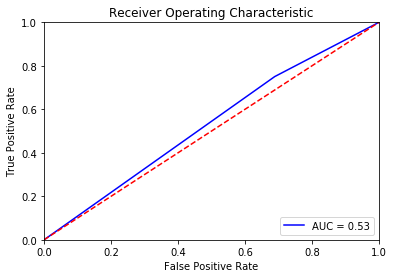

In [125]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [74]:
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.5 else 0 for pred in predictions]
confusion_matrix(y_test,predictions_matrix)

array([[416, 372],
       [314, 552]])